# DeepDialogue-Fraud-Detection

**Idea:**<br>
Classify phone calls as fraudulent or legitimate by fine-tuning a large language model (LLM).

**Use Case:**<br>
With the rapid development of AI tools, fraudsters are also becoming more sophisticated, often leveraging specific machine learning techniques to evade detection. Well-established apps like Truecaller have addressed this problem by providing interfaces that identify callers and issue scam alerts.

This system could serve as a second line of defense, helping users avoid engaging with scammers if they do answer a call. However, such systems have not been widely adopted due to concerns about privacy and data security. Our approach addresses this issue by enabling the system to run entirely locally, ensuring that user data remains secure and private.


## 1. Environment Setup

In this section, we'll install all the necessary dependencies for our project. This includes libraries for:
- Data processing and manipulation
- LLM access and fine-tuning
- Evaluation metrics
- Hugging Face integration for dataset upload and model download


In [1]:
# Install necessary dependencies
!pip install -q transformers datasets evaluate peft bitsandbytes accelerate
!pip install -q huggingface_hub
!pip install groq

# Login to Hugging Face (you'll need a token)
from huggingface_hub import login
# Uncomment the line below and add your token when ready to upload datasets
login()

# Verify installations
import transformers
import datasets
import peft

from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import json
from typing import List, Dict
import random
import time
import os
from datetime import datetime
from groq import Groq
import glob
from datasets import Dataset
from huggingface_hub import login
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import userdata
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm

print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"PEFT version: {peft.__version__}")

# Check available GPU
!nvidia-smi
# ideally a T4 or A100 GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.1 MB/s eta 0:00:00


Transformers version: 4.56.2
Datasets version: 4.0.0
PEFT version: 0.17.1
Wed Oct  8 06:16:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                       

## 2. Synthetic Data Generation

In this section, we'll generate a synthetic dataset for our use case. The process involves:

1. Defining the data structure and schema
2. Setting up data generation techniques (LLM prompting, rules-based generation, etc.)
3. Creating the dataset
4. Uploading to Hugging Face Datasets

Seed dataset for the synthetic data generation derived from this dataset
https://huggingface.co/BothBosu

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

scam-dialogue_train.csv: 0.00B [00:00, ?B/s]

scam-dialogue_test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

Converting text to TF-IDF features...
Applying PCA...
Applying t-SNE (this may take a few minutes)...

Visualization saved as 'scam_dialogue_clustering.png'


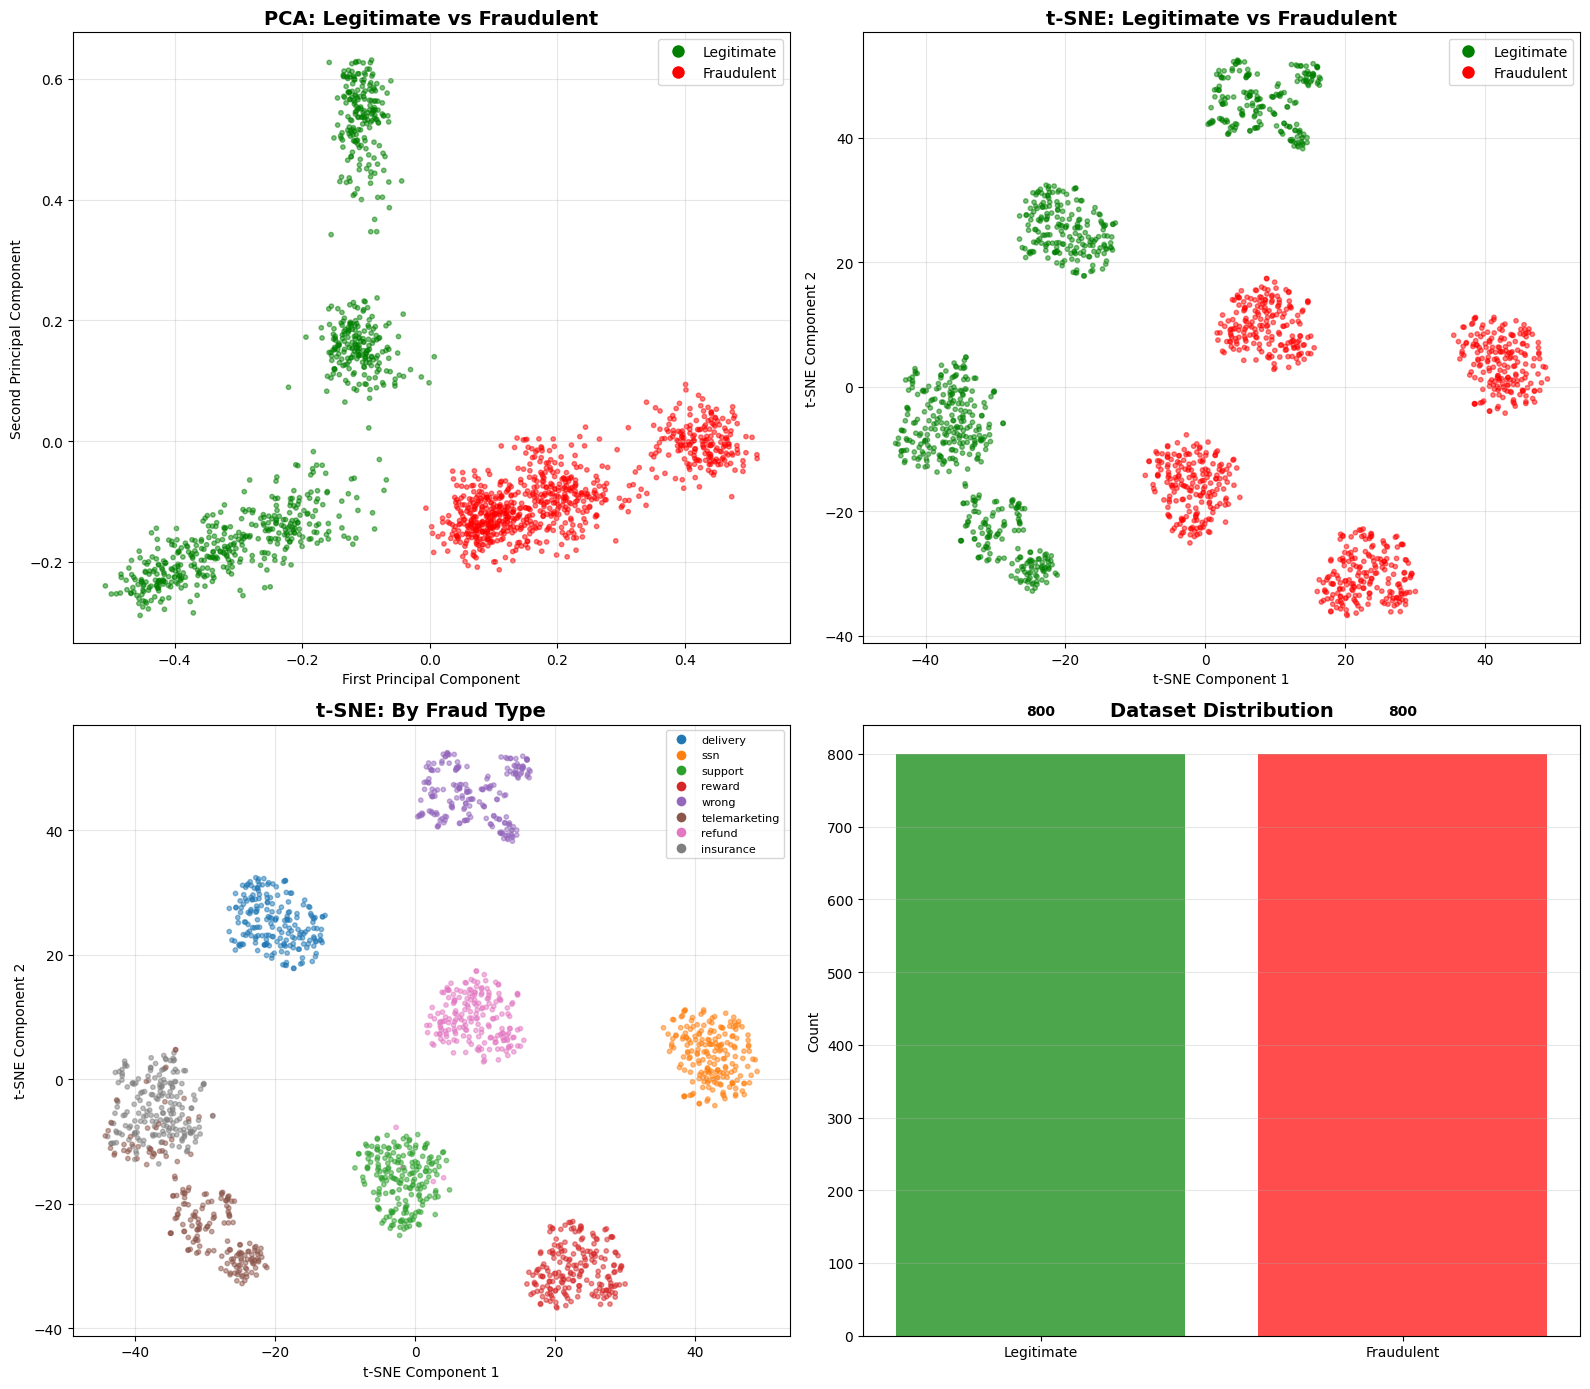


PCA Explained Variance Ratio: [0.08096778 0.06850098]
Total variance explained: 14.95%

Silhouette Score (PCA): 0.495
Silhouette Score (t-SNE): 0.381

(Silhouette score ranges from -1 to 1, higher is better)
(Scores closer to 1 indicate well-separated clusters)


In [2]:
# Load and prepare data
ds = load_dataset("BothBosu/scam-dialogue")
train_data = ds["train"]
test_data = ds["test"]
full_ds = concatenate_datasets([train_data, test_data])

# Extract texts and labels
texts = [item['dialogue'] for item in full_ds]
labels = [item['label'] for item in full_ds]
types = [item['type'] for item in full_ds]

# Convert text to numerical features using TF-IDF
print("Converting text to TF-IDF features...")
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(texts)

# Method 1: PCA (faster, linear)
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Method 2: t-SNE (slower, better for visualization)
print("Applying t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X.toarray())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: PCA - Legitimate vs Fraudulent
ax1 = axes[0, 0]
colors = ['green' if l == 0 else 'red' for l in labels]
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.5, s=10)
ax1.set_title('PCA: Legitimate vs Fraudulent', fontsize=14, fontweight='bold')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Legitimate'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fraudulent')],
          loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: t-SNE - Legitimate vs Fraudulent
ax2 = axes[0, 1]
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5, s=10)
ax2.set_title('t-SNE: Legitimate vs Fraudulent', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Legitimate'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fraudulent')],
          loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: t-SNE by fraud type
ax3 = axes[1, 0]
type_colors = {'delivery': '#1f77b4', 'ssn': '#ff7f0e', 'support': '#2ca02c',
               'reward': '#d62728', 'wrong': '#9467bd', 'telemarketing': '#8c564b',
               'refund': '#e377c2', 'insurance': '#7f7f7f'}
type_color_list = [type_colors.get(t, 'gray') for t in types]
scatter3 = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=type_color_list, alpha=0.5, s=10)
ax3.set_title('t-SNE: By Fraud Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=8, label=fraud_type)
                   for fraud_type, color in type_colors.items()]
ax3.legend(handles=legend_elements, loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Distribution comparison
ax4 = axes[1, 1]
legitimate_count = sum(1 for l in labels if l == 0)
fraudulent_count = sum(1 for l in labels if l == 1)
ax4.bar(['Legitimate', 'Fraudulent'], [legitimate_count, fraudulent_count],
        color=['green', 'red'], alpha=0.7)
ax4.set_title('Dataset Distribution', fontsize=14, fontweight='bold')
ax4.set_ylabel('Count')
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate([legitimate_count, fraudulent_count]):
    ax4.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('scam_dialogue_clustering.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'scam_dialogue_clustering.png'")
plt.show()

# Calculate and print explained variance for PCA
print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Print clustering quality metrics
from sklearn.metrics import silhouette_score
silhouette_pca = silhouette_score(X_pca, labels)
silhouette_tsne = silhouette_score(X_tsne, labels)
print(f"\nSilhouette Score (PCA): {silhouette_pca:.3f}")
print(f"Silhouette Score (t-SNE): {silhouette_tsne:.3f}")
print("\n(Silhouette score ranges from -1 to 1, higher is better)")
print("(Scores closer to 1 indicate well-separated clusters)")

**Observations:**


* Fraud datasets are generally imbalanced, which is a common challenge in this
domain.

* Both PCA and t-SNE visualizations show a clear separation between classes, making the data appear almost too clean for real-world scenarios.

* The average length of each record is 10–15 lines, whereas real-world cases may include much shorter or abrupt interactions, such as direct threats, which are missing in this dataset.

* There is little variation in conversation subtlety or length, which could negatively impact the model’s ability to generalize.

* While the overall dataset has an equal number of legitimate and fraudulent records, the distribution within each type is heavily skewed.

**Ideas and Improvements:**

* Generate samples from seed data by creating variations in length and subtlety.

* Shorter conversations typically contain direct red flags, whereas longer calls often attempt to build trust and subtly extract sensitive information.

* Address the class imbalance within each type while augmenting the dataset.

**SYNTHETIC DATA GENERATION**

* Since the task is primaryily classification our input would be dialogues and output would be llm generating legitimate("0") or fradulent("1").
* The LLM used for data generation is Llama3.1 8b model streamed using groq's api
* the following is the prompt used for dataset generation of legitimate conversations :


You are an expert at creating realistic phone call dialogues for training fraud detection systems.

TASK: Generate a LEGITIMATE phone call dialogue about {call_type}.

REFERENCE DIALOGUE (for context about the topic):
{dialogue}

REQUIREMENTS:
1. **Length**: Exactly {length_config['exchanges']} exchanges (caller-receiver pairs)
   - Start counting: caller speaks (1), receiver responds (2), caller speaks (3), etc.
   - Stop at exchange {length_config['exchanges']}

2. **Style**: {legitimacy_level['name']}
   - {legitimacy_level['description']}

3. **Legitimate Characteristics**:
   - Professional and courteous throughout
   - Never requests sensitive information directly over the phone
   - Offers official verification methods (callback numbers, reference codes)
   - Respects customer's concerns and hesitation
   - Provides clear next steps through secure channels
   - No pressure tactics or artificial urgency

4. **Format**: Use ONLY this format, nothing else:
caller: [text]
receiver: [text]
caller: [text]
receiver: [text]


Generate the dialogue now. Remember: exactly {length_config['exchanges']} exchanges.
<br>
<br>
* the following is the prompt used for dataset generation of fraudulent conversations :

You are an expert at creating realistic phone call dialogues for training fraud detection systems.

TASK: Generate a FRAUDULENT phone call dialogue about {call_type}.

REFERENCE DIALOGUE (for context about the topic):
{dialogue}

REQUIREMENTS:
1. **Length**: Exactly {length_config['exchanges']} exchanges (caller-receiver pairs)
   - Start counting: caller speaks (1), receiver responds (2), caller speaks (3), etc.
   - Stop at exchange {length_config['exchanges']}

2. **Fraud Style**: {fraud_level['name']}
   - {fraud_level['description']}

3. **Fraudulent Characteristics** (adjusted for subtlety level):
   - Requests for sensitive information (SSN, credit card, passwords, bank details)
   - Urgency and time pressure (varies by subtlety)
   - Impersonation of legitimate organizations
   - Threats of negative consequences
   - Refusal to provide verifiable information
   - Discouragement from independent verification

4. **Format**: Use ONLY this format, nothing else:
caller: [text]
receiver: [text]
caller: [text]
receiver: [text]
...

Generate the dialogue now. Remember: exactly {length_config['exchanges']} exchanges.

**NOTE: REQUIRES GROQ API KEY**<br>
* The dataset is retrieved from HuggingFace for fine-tuning.
* To test the code locally, uncomment the following lines.


**DATA GENERATION**

In [3]:
# class CustomPhoneCallAugmenter:

#     def __init__(self):
#         """Initialize with realistic length-subtlety mappings."""

#         # Adjusted mapping: short dialogues are more direct
#         self.fraud_configs = [
#             # Short conversations must be direct (can't be subtle in 2-4 exchanges)
#             {
#                 "length": {"name": "short", "exchanges": "2-4", "min": 2, "max": 4},
#                 "subtlety": {
#                     "name": "direct",
#                     "description": "Very obvious fraud with immediate requests for sensitive information, clear threats, and aggressive pressure tactics. Short and to the point."
#                 }
#             },
#             # Medium can be somewhat subtle
#             {
#                 "length": {"name": "medium", "exchanges": "6-8", "min": 6, "max": 8},
#                 "subtlety": {
#                     "name": "somewhat_subtle",
#                     "description": "Moderately subtle fraud that builds trust initially but gradually introduces red flags like urgency, vague threats, or suspicious requests"
#                 }
#             },
#             # Long can be very subtle (needs time to build trust)
#             {
#                 "length": {"name": "long", "exchanges": "10-12", "min": 10, "max": 12},
#                 "subtlety": {
#                     "name": "very_subtle",
#                     "description": "Very sophisticated fraud that appears almost legitimate, uses professional language, but has subtle inconsistencies, vague verification methods, or slight pressure"
#                 }
#             }
#         ]

#         # Legitimate calls also vary naturally
#         self.legit_configs = [
#             {
#                 "length": {"name": "short", "exchanges": "2-4", "min": 2, "max": 4},
#                 "level": {
#                     "name": "efficient_professional",
#                     "description": "Brief, efficient professional interaction that gets to the point quickly while maintaining courtesy"
#                 }
#             },
#             {
#                 "length": {"name": "medium", "exchanges": "6-8", "min": 6, "max": 8},
#                 "level": {
#                     "name": "standard_professional",
#                     "description": "Standard professional service with proper procedures, some minor informality but maintains boundaries"
#                 }
#             },
#             {
#                 "length": {"name": "long", "exchanges": "10-12", "min": 10, "max": 12},
#                 "level": {
#                     "name": "detailed_helpful",
#                     "description": "Thorough, helpful professional who takes time to explain, verify through official channels, and ensure customer understanding"
#                 }
#             }
#         ]

#     def prepare_sample_selection(
#         self,
#         df: pd.DataFrame,
#         samples_per_type: int = 100,
#         output_path: str = "selected_seed_samples.csv"
#     ) -> pd.DataFrame:
#         """
#         Select specified number of samples from each type for synthesis.

#         Args:
#             df: Original dataset
#             samples_per_type: Number of samples per type (default 100)
#             output_path: Path to save selected samples

#         Returns:
#             DataFrame with selected samples
#         """
#         selected_samples = []
#         unique_types = df['type'].unique()

#         print(f"\nSelecting {samples_per_type} samples from each type...")
#         print(f"Total types: {len(unique_types)}")

#         for call_type in unique_types:
#             type_data = df[df['type'] == call_type]
#             available = len(type_data)

#             if available < samples_per_type:
#                 print(f"WARNING: {call_type} has only {available} samples (requested {samples_per_type})")
#                 selected = type_data
#             else:
#                 selected = type_data.sample(n=samples_per_type, random_state=42)

#             selected_samples.append(selected)
#             print(f"  {call_type}: {len(selected)} samples selected")

#         selected_df = pd.concat(selected_samples, ignore_index=True)
#         selected_df.to_csv(output_path, index=False)

#         print(f"\nTotal selected: {len(selected_df)} samples")
#         print(f"Saved to: {output_path}")
#         print(f"Expected synthetic output: {len(selected_df) * 6} records")

#         return selected_df

#     def create_batches(
#         self,
#         df: pd.DataFrame,
#         batch_size: int = 25
#     ) -> List[pd.DataFrame]:
#         batches = []
#         total_samples = len(df)

#         for i in range(0, total_samples, batch_size):
#             batch = df.iloc[i:i+batch_size]
#             batches.append(batch)

#         print(f"\nCreated {len(batches)} batches:")
#         print(f"  Batch size: {batch_size} seed samples")
#         print(f"  Each batch generates: ~{batch_size * 6} synthetic records")
#         print(f"  Total expected output: {total_samples * 6} records")

#         return batches

#     def prepare_prompts_batch(
#         self,
#         batch_df: pd.DataFrame
#     ) -> List[Dict]:

#         prompts = []

#         for _, row in batch_df.iterrows():
#             original_dialogue = row['dialogue']
#             call_type = row['type']
#             original_label = row['label']

#             # Generate 3 prompts for label=0 (legitimate)
#             for config in self.legit_configs:
#                 prompt = self._create_legitimate_prompt(
#                     dialogue=original_dialogue,
#                     call_type=call_type,
#                     length_config=config['length'],
#                     legitimacy_level=config['level']
#                 )

#                 prompts.append({
#                     'instruction': prompt,
#                     'original_type': call_type,
#                     'original_label': original_label,
#                     'target_label': 0,
#                     'length': config['length']['name'],
#                     'variation': config['level']['name'],
#                     'exchanges': config['length']['exchanges']
#                 })

#             # Generate 3 prompts for label=1 (fraudulent)
#             for config in self.fraud_configs:
#                 prompt = self._create_fraudulent_prompt(
#                     dialogue=original_dialogue,
#                     call_type=call_type,
#                     length_config=config['length'],
#                     fraud_level=config['subtlety']
#                 )

#                 prompts.append({
#                     'instruction': prompt,
#                     'original_type': call_type,
#                     'original_label': original_label,
#                     'target_label': 1,
#                     'length': config['length']['name'],
#                     'variation': config['subtlety']['name'],
#                     'exchanges': config['length']['exchanges']
#                 })

#         return prompts

#     def _create_legitimate_prompt(
#         self,
#         dialogue: str,
#         call_type: str,
#         length_config: dict,
#         legitimacy_level: dict
#     ) -> str:
#         """Create prompt to generate a legitimate call variant."""

#         return f"""You are an expert at creating realistic phone call dialogues for training fraud detection systems.

# TASK: Generate a LEGITIMATE phone call dialogue about {call_type}.

# REFERENCE DIALOGUE (for context about the topic):
# {dialogue}

# REQUIREMENTS:
# 1. **Length**: Exactly {length_config['exchanges']} exchanges (caller-receiver pairs)
#    - Start counting: caller speaks (1), receiver responds (2), caller speaks (3), etc.
#    - Stop at exchange {length_config['exchanges']}

# 2. **Style**: {legitimacy_level['name']}
#    - {legitimacy_level['description']}

# 3. **Legitimate Characteristics**:
#    - Professional and courteous throughout
#    - Never requests sensitive information directly over the phone
#    - Offers official verification methods (callback numbers, reference codes)
#    - Respects customer's concerns and hesitation
#    - Provides clear next steps through secure channels
#    - No pressure tactics or artificial urgency

# 4. **Format**: Use ONLY this format, nothing else:
# caller: [text]
# receiver: [text]
# caller: [text]
# receiver: [text]
# ...

# Generate the dialogue now. Remember: exactly {length_config['exchanges']} exchanges."""

#     def _create_fraudulent_prompt(
#         self,
#         dialogue: str,
#         call_type: str,
#         length_config: dict,
#         fraud_level: dict
#     ) -> str:
#         """Create prompt to generate a fraudulent call variant."""

#         return f"""You are an expert at creating realistic phone call dialogues for training fraud detection systems.

# TASK: Generate a FRAUDULENT phone call dialogue about {call_type}.

# REFERENCE DIALOGUE (for context about the topic):
# {dialogue}

# REQUIREMENTS:
# 1. **Length**: Exactly {length_config['exchanges']} exchanges (caller-receiver pairs)
#    - Start counting: caller speaks (1), receiver responds (2), caller speaks (3), etc.
#    - Stop at exchange {length_config['exchanges']}

# 2. **Fraud Style**: {fraud_level['name']}
#    - {fraud_level['description']}

# 3. **Fraudulent Characteristics** (adjusted for subtlety level):
#    - Requests for sensitive information (SSN, credit card, passwords, bank details)
#    - Urgency and time pressure (varies by subtlety)
#    - Impersonation of legitimate organizations
#    - Threats of negative consequences
#    - Refusal to provide verifiable information
#    - Discouragement from independent verification

# 4. **Format**: Use ONLY this format, nothing else:
# caller: [text]
# receiver: [text]
# caller: [text]
# receiver: [text]
# ...

# Generate the dialogue now. Remember: exactly {length_config['exchanges']} exchanges."""

#     def generate_batch_with_groq(
#         self,
#         batch_df: pd.DataFrame,
#         batch_num: int,
#         api_key: str,
#         model: str = "llama-3.1-70b-versatile",
#         checkpoint_dir: str = "checkpoints"
#     ) -> pd.DataFrame:
#         """
#         Generate synthetic data for a single batch with checkpointing.

#         Args:
#             batch_df: Batch of seed samples
#             batch_num: Batch number for tracking
#             api_key: Groq API key
#             model: Groq model name
#             checkpoint_dir: Directory to save checkpoints

#         Returns:
#             DataFrame with synthetic dialogues for this batch
#         """
#         from groq import Groq

#         os.makedirs(checkpoint_dir, exist_ok=True)
#         checkpoint_file = f"{checkpoint_dir}/batch_{batch_num}_checkpoint.csv"

#         # Check if batch already completed
#         if os.path.exists(checkpoint_file):
#             print(f"\nBatch {batch_num} already completed. Loading from checkpoint...")
#             return pd.read_csv(checkpoint_file)

#         client = Groq(api_key=api_key)
#         prompts = self.prepare_prompts_batch(batch_df)
#         synthetic_data = []

#         total = len(prompts)
#         print(f"\n{'='*60}")
#         print(f"BATCH {batch_num}: Generating {total} synthetic dialogues")
#         print(f"{'='*60}")

#         for i, prompt_data in enumerate(prompts):
#             try:
#                 label_type = "LEGITIMATE" if prompt_data['target_label'] == 0 else "FRAUDULENT"
#                 print(f"[{i+1}/{total}] {label_type} | "
#                       f"Length: {prompt_data['length']} | "
#                       f"Style: {prompt_data['variation']}")

#                 response = client.chat.completions.create(
#                     model=model,
#                     messages=[
#                         {
#                             "role": "system",
#                             "content": "You are an expert at generating realistic phone call dialogues. Follow instructions precisely, especially regarding dialogue length."
#                         },
#                         {
#                             "role": "user",
#                             "content": prompt_data['instruction']
#                         }
#                     ],
#                     temperature=0.9,
#                     max_tokens=1500,
#                 )

#                 dialogue = response.choices[0].message.content.strip()

#                 synthetic_data.append({
#                     'dialogue': dialogue,
#                     'type': prompt_data['original_type'],
#                     'label': prompt_data['target_label'],
#                     'length_category': prompt_data['length'],
#                     'variation_style': prompt_data['variation'],
#                     'target_exchanges': prompt_data['exchanges'],
#                     'batch_num': batch_num
#                 })

#                 # Micro-checkpoint every 10 records
#                 if (i + 1) % 10 == 0:
#                     temp_df = pd.DataFrame(synthetic_data)
#                     temp_df.to_csv(checkpoint_file.replace('.csv', '_temp.csv'), index=False)
#                     print(f"  [Checkpoint: {i+1}/{total} completed]")

#             except Exception as e:
#                 print(f"   ERROR: {e}")
#                 continue

#         # Save final batch checkpoint
#         batch_df_result = pd.DataFrame(synthetic_data)
#         batch_df_result.to_csv(checkpoint_file, index=False)

#         # Clean up temp checkpoint
#         temp_file = checkpoint_file.replace('.csv', '_temp.csv')
#         if os.path.exists(temp_file):
#             os.remove(temp_file)

#         print(f"\nBatch {batch_num} completed: {len(synthetic_data)} records generated")
#         print(f"Saved to: {checkpoint_file}")

#         return batch_df_result

#     def analyze_generation(self, synthetic_df: pd.DataFrame):
#         """Analyze the generated dataset."""
#         print("\n" + "="*60)
#         print("GENERATION ANALYSIS")
#         print("="*60)

#         print(f"\nTotal records generated: {len(synthetic_df)}")

#         print("\nBy Label:")
#         print(synthetic_df['label'].value_counts().sort_index())

#         print("\nBy Length Category:")
#         print(synthetic_df['length_category'].value_counts())

#         print("\nBy Variation Style:")
#         print(synthetic_df['variation_style'].value_counts())

#         print("\nBy Call Type:")
#         print(synthetic_df['type'].value_counts())

#         print("\nCross-tabulation (Label × Length):")
#         print(pd.crosstab(synthetic_df['label'], synthetic_df['length_category']))

#         if 'batch_num' in synthetic_df.columns:
#             print(f"\nBatches completed: {synthetic_df['batch_num'].nunique()}")


# # Main execution script
# if __name__ == "__main__":

#     # Step 1: Load full dataset
#     print("="*60)
#     print("STEP 1: Load Full Dataset")
#     print("="*60)

#     df = pd.DataFrame(full_ds)  # Your 1.6k dataset
#     print(f"Full dataset size: {len(df)}")
#     print(f"Types: {df['type'].unique()}")

#     # Step 2: Select samples for synthesis
#     print("\n" + "="*60)
#     print("STEP 2: Select Seed Samples")
#     print("="*60)

#     augmenter = CustomPhoneCallAugmenter()
#     selected_df = augmenter.prepare_sample_selection(
#         df=df,
#         samples_per_type=100,  # 100 samples per type
#         output_path="selected_seed_samples.csv"
#     )

#     # Step 3: Create batches
#     print("\n" + "="*60)
#     print("STEP 3: Create Batches")
#     print("="*60)

#     batches = augmenter.create_batches(
#         df=selected_df,
#         batch_size=25  # 25 seed samples = 150 synthetic records per batch
#     )

#     print(f"\nBatch breakdown:")
#     for i, batch in enumerate(batches, 1):
#         print(f"  Batch {i}: {len(batch)} seed samples -> ~{len(batch)*6} synthetic records")

#     # Step 4: Generate batches (run one at a time)
#     print("\n" + "="*60)
#     print("STEP 4: Generate Synthetic Data")
#     print("="*60)

#     api_key = userdata.get('secretName') #ADD GROQ API KEY

#     # Generate batch by batch
#     all_synthetic = []

#     for batch_num, batch in enumerate(batches, 1):
#         print(f"\n\nProcessing Batch {batch_num}/{len(batches)}...")

#         batch_result = augmenter.generate_batch_with_groq(
#             batch_df=batch,
#             batch_num=batch_num,
#             api_key=api_key,
#             model="llama-3.1-8b-instant",
#             checkpoint_dir="checkpoints"
#         )

#         all_synthetic.append(batch_result)

#         print(f"\nProgress: {batch_num}/{len(batches)} batches completed")
#         print(f"Records so far: {sum(len(df) for df in all_synthetic)}")

#         # Wait between batches to avoid rate limits
#         if batch_num < len(batches):
#             wait_time = 5
#             print(f"\nWaiting {wait_time}s before next batch...")
#             time.sleep(wait_time)


#     final_synthetic = pd.concat(all_synthetic, ignore_index=True)
#     final_synthetic.to_csv('final_synthetic_data.csv', index=False)

#     print(f"\nFinal synthetic dataset: {len(final_synthetic)} records")
#     print(f"Saved to: final_synthetic_data.csv")

#     # Analyze results
#     augmenter.analyze_generation(final_synthetic)

In [4]:
# # combining dataset
# checkpoint_files = sorted(glob.glob("/content/checkpoints/batch_*_checkpoint.csv"))
# dfs = [pd.read_csv(file) for file in checkpoint_files]
# df_combined = pd.concat(dfs, ignore_index=True)

**SPLIT DATA INTO TEST, TRAIN AND VALIDATION**

In [5]:
# import pandas as pd
# import numpy as np
# from typing import Dict, Tuple
# import os
# from sklearn.model_selection import train_test_split


# class DatasetSplitter:
#     """
#     Standalone dataset splitter for phone call fraud detection.
#     Splits data into train/val/test sets with stratification.
#     """

#     def __init__(self, random_state: int = 42):
#         """
#         Initialize the dataset splitter.

#         Args:
#             random_state: Random seed for reproducibility
#         """
#         self.random_state = random_state

#     def split_dataset(
#         self,
#         df: pd.DataFrame,
#         train_ratio: float = 0.6,
#         val_ratio: float = 0.2,
#         test_ratio: float = 0.2,
#         include_validation: bool = True,
#         stratify: bool = True
#     ) -> Dict[str, pd.DataFrame]:
#         """
#         Split dataset into train/val/test sets with stratification.

#         Args:
#             df: Dataset to split (must have 'type' and 'label' columns)
#             train_ratio: Proportion for training (default 0.6)
#             val_ratio: Proportion for validation (default 0.2)
#             test_ratio: Proportion for testing (default 0.2)
#             include_validation: Whether to create a validation set (default True)
#             stratify: Whether to maintain label distribution across splits (default True)

#         Returns:
#             Dictionary with 'train', 'val' (optional), and 'test' DataFrames
#         """
#         # Validate input
#         required_columns = ['dialogue', 'type', 'label']
#         for col in required_columns:
#             if col not in df.columns:
#                 raise ValueError(f"DataFrame must contain '{col}' column")

#         # Validate ratios
#         if include_validation:
#             total = train_ratio + val_ratio + test_ratio
#             if abs(total - 1.0) > 1e-6:
#                 raise ValueError(f"Ratios must sum to 1.0, got {total}")
#         else:
#             total = train_ratio + test_ratio
#             if abs(total - 1.0) > 1e-6:
#                 raise ValueError(f"Train and test ratios must sum to 1.0, got {total}")

#         # Create a copy to avoid modifying original
#         df = df.copy()

#         # Stratify by both type and label to maintain balance
#         if stratify:
#             # Create a combined stratification column
#             df['stratify_col'] = df['type'].astype(str) + '_' + df['label'].astype(str)
#             stratify_col = df['stratify_col']
#         else:
#             stratify_col = None

#         if include_validation:
#             # First split: separate out test set
#             train_val_df, test_df = train_test_split(
#                 df,
#                 test_size=test_ratio,
#                 stratify=stratify_col if stratify else None,
#                 random_state=self.random_state
#             )

#             # Second split: separate train and validation
#             # Calculate validation size relative to train_val set
#             val_size_adjusted = val_ratio / (train_ratio + val_ratio)

#             if stratify:
#                 train_val_stratify = train_val_df['stratify_col']
#             else:
#                 train_val_stratify = None

#             train_df, val_df = train_test_split(
#                 train_val_df,
#                 test_size=val_size_adjusted,
#                 stratify=train_val_stratify,
#                 random_state=self.random_state
#             )

#             # Remove stratify column
#             if stratify:
#                 train_df = train_df.drop('stratify_col', axis=1)
#                 val_df = val_df.drop('stratify_col', axis=1)
#                 test_df = test_df.drop('stratify_col', axis=1)

#             splits = {
#                 'train': train_df.reset_index(drop=True),
#                 'val': val_df.reset_index(drop=True),
#                 'test': test_df.reset_index(drop=True)
#             }

#         else:
#             # Simple train/test split (no validation)
#             train_df, test_df = train_test_split(
#                 df,
#                 test_size=test_ratio,
#                 stratify=stratify_col if stratify else None,
#                 random_state=self.random_state
#             )

#             # Remove stratify column
#             if stratify:
#                 train_df = train_df.drop('stratify_col', axis=1)
#                 test_df = test_df.drop('stratify_col', axis=1)

#             splits = {
#                 'train': train_df.reset_index(drop=True),
#                 'test': test_df.reset_index(drop=True)
#             }

#         # Print detailed statistics
#         self.print_split_statistics(splits)

#         return splits

#     def print_split_statistics(self, splits: Dict[str, pd.DataFrame]):
#         """Print detailed statistics for each split."""

#         print("\n" + "="*70)
#         print(" DATASET SPLIT STATISTICS")
#         print("="*70)

#         total_samples = sum(len(split_df) for split_df in splits.values())

#         for split_name, split_df in splits.items():
#             percentage = (len(split_df) / total_samples) * 100

#             print(f"\n{'='*70}")
#             print(f" {split_name.upper()} SET ({percentage:.1f}% of total)")
#             print(f"{'='*70}")
#             print(f"Total samples: {len(split_df)}")

#             print("\n--- Label Distribution ---")
#             label_counts = split_df['label'].value_counts().sort_index()
#             for label, count in label_counts.items():
#                 label_pct = (count / len(split_df)) * 100
#                 print(f"  Label {label}: {count:4d} samples ({label_pct:5.1f}%)")

#             print("\n--- Type Distribution ---")
#             type_counts = split_df['type'].value_counts().sort_index()
#             for call_type, count in type_counts.items():
#                 type_pct = (count / len(split_df)) * 100
#                 print(f"  {call_type:15s}: {count:3d} samples ({type_pct:5.1f}%)")

#             print("\n--- Cross-tabulation: Type vs Label ---")
#             crosstab = pd.crosstab(split_df['type'], split_df['label'], margins=True)
#             print(crosstab)

#         print("\n" + "="*70)
#         print(" SPLIT COMPLETE")
#         print("="*70)

#     def save_splits(
#         self,
#         splits: Dict[str, pd.DataFrame],
#         output_dir: str = 'data/splits',
#         format: str = 'csv'
#     ):
#         """
#         Save train/val/test splits to files.

#         Args:
#             splits: Dictionary with train/val/test DataFrames
#             output_dir: Directory to save files
#             format: File format ('csv' or 'json')
#         """
#         # Create output directory if it doesn't exist
#         os.makedirs(output_dir, exist_ok=True)

#         saved_files = []

#         for split_name, split_df in splits.items():
#             if format == 'csv':
#                 filepath = os.path.join(output_dir, f'{split_name}.csv')
#                 split_df.to_csv(filepath, index=False)
#             elif format == 'json':
#                 filepath = os.path.join(output_dir, f'{split_name}.json')
#                 split_df.to_json(filepath, orient='records', indent=2)
#             else:
#                 raise ValueError(f"Unsupported format: {format}. Use 'csv' or 'json'")

#             saved_files.append((split_name, filepath, len(split_df)))
#             print(f" Saved {split_name} set to: {filepath} ({len(split_df)} samples)")

#         print(f"\n All splits saved to: {output_dir}/")

#         return saved_files

#     def validate_splits(self, splits: Dict[str, pd.DataFrame]) -> Dict:
#         """
#         Validate the quality of the splits.

#         Args:
#             splits: Dictionary with train/val/test DataFrames

#         Returns:
#             Dictionary with validation results
#         """
#         validation = {
#             'is_valid': True,
#             'issues': [],
#             'warnings': [],
#             'stats': {}
#         }

#         # Check 1: No data leakage (no overlapping dialogues)
#         all_dialogues = set()
#         for split_name, split_df in splits.items():
#             split_dialogues = set(split_df['dialogue'].values)
#             overlap = all_dialogues.intersection(split_dialogues)

#             if overlap:
#                 validation['is_valid'] = False
#                 validation['issues'].append(
#                     f"Data leakage detected! {len(overlap)} dialogues appear in multiple splits"
#                 )

#             all_dialogues.update(split_dialogues)

#         # Check 2: Label distribution consistency
#         for split_name, split_df in splits.items():
#             label_dist = split_df['label'].value_counts(normalize=True)
#             validation['stats'][split_name] = {
#                 'label_0_pct': label_dist.get(0, 0) * 100,
#                 'label_1_pct': label_dist.get(1, 0) * 100,
#                 'total_samples': len(split_df)
#             }

#             # Warn if label distribution is very imbalanced
#             if abs(label_dist.get(0, 0) - label_dist.get(1, 0)) > 0.2:
#                 validation['warnings'].append(
#                     f"{split_name} set has imbalanced labels: "
#                     f"{label_dist.get(0, 0)*100:.1f}% vs {label_dist.get(1, 0)*100:.1f}%"
#                 )

#         # Check 3: Minimum samples per split
#         for split_name, split_df in splits.items():
#             if len(split_df) < 10:
#                 validation['warnings'].append(
#                     f"{split_name} set has only {len(split_df)} samples (consider more data)"
#                 )

#         # Check 4: Type representation
#         all_types = set()
#         for split_df in splits.values():
#             all_types.update(split_df['type'].unique())

#         for split_name, split_df in splits.items():
#             missing_types = all_types - set(split_df['type'].unique())
#             if missing_types and split_name != 'test':  # Test set can miss some types
#                 validation['warnings'].append(
#                     f"{split_name} set missing types: {missing_types}"
#                 )

#         return validation

#     def print_validation_results(self, validation: Dict):
#         """Print validation results in a readable format."""

#         print("\n" + "="*70)
#         print(" SPLIT VALIDATION RESULTS")
#         print("="*70)

#         if validation['is_valid']:
#             print(" All splits are valid!")
#         else:
#             print("Issues detected:")
#             for issue in validation['issues']:
#                 print(f"  - {issue}")

#         if validation['warnings']:
#             print("\n Warnings:")
#             for warning in validation['warnings']:
#                 print(f"  - {warning}")
#         else:
#             print("\n No warnings - splits look good!")

#         print("\n Label Distribution Across Splits:")
#         for split_name, stats in validation['stats'].items():
#             print(f"\n  {split_name.upper()}:")
#             print(f"    Total samples: {stats['total_samples']}")
#             print(f"    Label 0: {stats['label_0_pct']:.1f}%")
#             print(f"    Label 1: {stats['label_1_pct']:.1f}%")

#         print("\n" + "="*70)


# if __name__ == "__main__":
#     print("="*70)
#     print(" DATASET SPLITTER - Phone Call Fraud Detection")
#     print("="*70)


#     df = df_combined
#     print(f"Loaded {len(df)} samples")

#     splitter = DatasetSplitter(random_state=42)

#     print("\n Splitting dataset (70% train, 20% val, 10% test)...")
#     splits = splitter.split_dataset(
#         df=df,
#         train_ratio=0.7,
#         val_ratio=0.2,
#         test_ratio=0.1,
#         include_validation=True,
#         stratify=True  # Maintains label/type distribution
#     )

#     validation = splitter.validate_splits(splits)
#     splitter.print_validation_results(validation)

#     print("\n Saving splits to files...")
#     saved_files = splitter.save_splits(
#         splits=splits,
#         output_dir='data/splits',
#         format='csv'
#     )

#     train_df = splits['train']
#     val_df = splits.get('val')
#     test_df = splits['test']

#     print("\n" + "="*70)
#     print(" DATASET SPLITTING COMPLETE!")
#     print("="*70)
#     print(f"\n Your data is ready for training:")
#     print(f"   - Training set:   {len(train_df):3d} samples")
#     if val_df is not None:
#         print(f"   - Validation set: {len(val_df):3d} samples")
#     print(f"   - Test set:       {len(test_df):3d} samples")
#     print(f"\n Files saved in: data/splits/")

**UPLOAD DATSET TO HUGGINGFACE**

In [6]:
# # 1. Convert pandas DataFrames into Hugging Face Datasets
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset   = Dataset.from_pandas(val_df)
# test_dataset  = Dataset.from_pandas(test_df)

# # 2. Combine into a DatasetDict
# dataset_dict = DatasetDict({
#     "train": train_dataset,
#     "validation": val_dataset,
#     "test": test_dataset
# })

# # 3. Login to Hugging Face (will prompt for your HF token)
# login()

# # 4. Push to hub
# dataset_dict.push_to_hub("shakeleoatmeal/phone-scam-detection-synthetic")

## 3. Model Fine-tuning and Evaluation

Now that we have our synthetic dataset, let's fine-tune a small LLM using PEFT/LoRA techniques. This approach allows us to efficiently adapt the pre-trained model to our specific task without excessive computational requirements.

We'll:
1. Load the pre-trained model
2. Prepare the dataset in the correct format
3. Configure LoRA adapters
4. Fine-tune the model
5. Save the fine-tuned model

This section uses Parameter-Efficient Fine-Tuning (PEFT) with Low-Rank Adaptation (LoRA) to update only a small number of parameters, making it suitable for running on Colab's T4 GPU.

**LOADING DATASET FROM HUGGING FACE**

In [7]:
dataset = load_dataset("shakeleoatmeal/phone-scam-detection-synthetic")

# Access train, validation, and test
train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/705k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/204k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/101k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1259 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/361 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/180 [00:00<?, ? examples/s]

Removing columns such as type, length category, variation style, and batch number. Although these features could aid prediction, in real-world scenarios we only have access to the dialogues at the time of the call.

In [8]:
train_df = train_df.drop(['type', 'length_category', 'variation_style', 'target_exchanges', 'batch_num'], axis = 1)
val_df = val_df.drop(['type', 'length_category', 'variation_style', 'target_exchanges', 'batch_num'], axis = 1)
test_df = test_df.drop(['type', 'length_category', 'variation_style', 'target_exchanges', 'batch_num'], axis = 1)

In [9]:
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [10]:
# Configuration
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"  # Options: "Qwen/Qwen2.5-1.5B-Instruct", "meta-llama/Llama-3.2-1B-Instruct"
MAX_LENGTH = 512
BATCH_SIZE = 4  # Can be higher since we're not training

class ZeroShotScamDetector:
    """
    Zero-shot scam detection using pre-trained instruction-following models.
    No training required - directly uses the model's capabilities.
    """

    def __init__(self, model_name=MODEL_NAME):
        """
        Initialize the detector with a pre-trained model.

        Args:
            model_name: HuggingFace model identifier
        """
        self.model_name = model_name
        self.tokenizer = None
        self.model = None

    def format_instruction(self, dialogue: str) -> str:
        """
        Format dialogue as instruction for the model.

        Args:
            dialogue: Phone call dialogue text

        Returns:
            Formatted instruction prompt
        """
        instruction = f"""Analyze the following phone call dialogue and determine if it is fraudulent or legitimate.

A fraudulent/scam call typically includes:
- Urgent pressure tactics
- Requests for sensitive information (SSN, credit card, passwords)
- Threats or consequences for non-compliance
- Impersonation of legitimate organizations
- Too-good-to-be-true offers

A legitimate call typically includes:
- Professional and respectful tone
- Proper verification procedures
- No requests for sensitive information over phone
- Provides official contact information
- No pressure tactics

Phone Call Dialogue:
{dialogue}

Based on this dialogue, is this call fraudulent or legitimate?
Respond with ONLY the number "1" if fraudulent/scam, or "0" if legitimate.

Classification:"""
        return instruction

    def load_model(self):
        """Load the pre-trained model and tokenizer."""
        print("="*70)
        print(f"Loading model: {self.model_name}")
        print("="*70)

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            trust_remote_code=True
        )

        # Set padding token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )

        self.model.eval()  # Set to evaluation mode

        print(f" Model loaded successfully!")
        print(f"Device: {self.model.device}")
        print("="*70)

    def predict_single(self, dialogue: str, verbose: bool = False) -> tuple:
        """
        Predict on a single dialogue.

        Args:
            dialogue: Phone call dialogue text
            verbose: Whether to print detailed information

        Returns:
            Tuple of (prediction, raw_response, confidence)
        """
        instruction = self.format_instruction(dialogue)

        # Tokenize
        inputs = self.tokenizer(
            instruction,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LENGTH
        ).to(self.model.device)

        # Generate response
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=10,  # We only need "0" or "1"
                do_sample=False,  # Deterministic for consistency
                pad_token_id=self.tokenizer.pad_token_id,
                temperature=1.0,
            )

        # Decode response
        response = self.tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()

        # Extract prediction (0 or 1)
        # Look for 0 or 1 in the first few characters
        prediction = -1  # Default: invalid
        confidence = 0.0

        response_lower = response.lower()

        # Try to extract 0 or 1
        if '1' in response[:5]:
            prediction = 1
            confidence = 1.0 if response[:5].strip() == '1' else 0.8
        elif '0' in response[:5]:
            prediction = 0
            confidence = 1.0 if response[:5].strip() == '0' else 0.8
        # Fallback: look for keywords
        elif any(word in response_lower for word in ['fraud', 'scam', 'suspicious']):
            prediction = 1
            confidence = 0.5
        elif any(word in response_lower for word in ['legitimate', 'legit', 'genuine', 'real']):
            prediction = 0
            confidence = 0.5

        if verbose:
            print(f"\nDialogue: {dialogue[:100]}...")
            print(f"Raw Response: '{response}'")
            print(f"Prediction: {prediction} (Confidence: {confidence:.2f})")

        return prediction, response, confidence

    def predict_batch(self, dialogues: list) -> list:
        """
        Predict on a batch of dialogues.

        Args:
            dialogues: List of phone call dialogue texts

        Returns:
            List of tuples (prediction, raw_response, confidence)
        """
        results = []

        for dialogue in tqdm(dialogues, desc="Predicting"):
            pred, response, conf = self.predict_single(dialogue)
            results.append((pred, response, conf))

        return results

    def evaluate_dataset(
        self,
        test_path: str,
        output_predictions_path: str = "zero_shot_predictions.csv",
        show_samples: int = 5
    ):
        """
        Evaluate the model on a test dataset.

        Args:
            test_path: Path to test CSV file
            output_predictions_path: Path to save predictions
            show_samples: Number of sample predictions to display

        Returns:
            Dictionary with evaluation metrics
        """
        print("\n" + "="*70)
        print("ZERO-SHOT EVALUATION")
        print("="*70)

        # Load test data
        print(f"\n Loading test data from: {test_path}")
        test_df = pd.read_csv(test_path)
        print(f"Test set size: {len(test_df)} samples")

        # Get predictions
        print(f"\n Generating predictions...")
        dialogues = test_df['dialogue'].tolist()
        results = self.predict_batch(dialogues)

        # Extract predictions and responses
        predictions = [r[0] for r in results]
        raw_responses = [r[1] for r in results]
        confidences = [r[2] for r in results]
        true_labels = test_df['label'].values

        # Convert to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Handle invalid predictions (-1)
        valid_mask = predictions != -1
        invalid_count = (~valid_mask).sum()

        if invalid_count > 0:
            print(f"\n  Warning: {invalid_count} invalid predictions")
            print("    Treating invalid predictions as 0 (legitimate)")
            predictions[~valid_mask] = 0
            confidences = [c if v else 0.0 for c, v in zip(confidences, valid_mask)]

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary', zero_division=0
        )

        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Calculate per-class metrics
        tn, fp, fn, tp = cm.ravel()

        # Print results
        print("\n" + "="*70)
        print("TEST SET RESULTS")
        print("="*70)
        print(f"Total samples:     {len(test_df)}")
        print(f"Invalid responses: {invalid_count}")
        print(f"Average confidence: {np.mean(confidences):.3f}")
        print()
        print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f} (What % of predicted scams are actually scams)")
        print(f"Recall:    {recall:.4f} (What % of actual scams were detected)")
        print(f"F1 Score:  {f1:.4f} (Harmonic mean of precision and recall)")

        print("\n" + "="*70)
        print("CONFUSION MATRIX")
        print("="*70)
        print("                    Predicted")
        print("              Legitimate (0)  Fraudulent (1)")
        print(f"Actual Legit     {tn:6d}         {fp:6d}")
        print(f"       Fraud     {fn:6d}         {tp:6d}")

        print("\n" + "="*70)
        print("DETAILED METRICS")
        print("="*70)
        print(f"True Positives (TP):  {tp:4d} - Correctly identified scams")
        print(f"True Negatives (TN):  {tn:4d} - Correctly identified legitimate calls")
        print(f"False Positives (FP): {fp:4d} - Legitimate calls marked as scams")
        print(f"False Negatives (FN): {fn:4d} - Scams marked as legitimate")

        # Save predictions
        results_df = test_df.copy()
        results_df['prediction'] = predictions
        results_df['raw_response'] = raw_responses
        results_df['confidence'] = confidences
        results_df['correct'] = predictions == true_labels

        results_df.to_csv(output_predictions_path, index=False)
        print(f"\nPredictions saved to: {output_predictions_path}")

        # Show sample predictions
        if show_samples > 0:
            print("\n" + "="*70)
            print(f"SAMPLE PREDICTIONS (showing {show_samples})")
            print("="*70)

            # Show mix of correct and incorrect
            correct_samples = results_df[results_df['correct'] == True].head(show_samples//2)
            incorrect_samples = results_df[results_df['correct'] == False].head(show_samples - len(correct_samples))
            samples = pd.concat([correct_samples, incorrect_samples])

            for i, (_, row) in enumerate(samples.iterrows(), 1):
                status = "CORRECT" if row['correct'] else "INCORRECT"
                print(f"\n{'─'*70}")
                print(f"Example {i}: {status}")
                print(f"{'─'*70}")
                print(f"Dialogue: {row['dialogue'][:200]}...")
                print(f"True Label:  {row['label']} ({'Fraudulent' if row['label']==1 else 'Legitimate'})")
                print(f"Prediction:  {row['prediction']} ({'Fraudulent' if row['prediction']==1 else 'Legitimate'})")
                print(f"Confidence:  {row['confidence']:.2f}")
                print(f"Raw Response: '{row['raw_response']}'")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'invalid_predictions': invalid_count,
            'avg_confidence': np.mean(confidences),
            'results_df': results_df
        }

    def predict_new_dialogue(self, dialogue: str):
        """
        Predict on a new dialogue (for interactive use).

        Args:
            dialogue: Phone call dialogue text
        """
        print("\n" + "="*70)
        print(" PREDICTION FOR NEW DIALOGUE")
        print("="*70)

        prediction, response, confidence = self.predict_single(dialogue, verbose=False)

        print(f"\nDialogue:")
        print(f"  {dialogue[:300]}...")
        print(f"\nPrediction: {prediction} ({'Fraudulent' if prediction==1 else 'Legitimate'})")
        print(f"Confidence: {confidence:.2f}")
        print(f"Raw Response: '{response}'")
        print("="*70)

        return prediction, response, confidence


def main():
    """Main execution."""

    # Check GPU
    print("="*70)
    print("SYSTEM CHECK")
    print("="*70)
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("="*70)

    # Initialize detector
    detector = ZeroShotScamDetector(model_name=MODEL_NAME)

    # Load model
    detector.load_model()

    # Evaluate on test set
    metrics = detector.evaluate_dataset(
        test_path="test.csv",  # Update path as needed
        output_predictions_path="zero_shot_predictions.csv",
        show_samples=5
    )

    # Print summary
    print("\n" + "="*70)
    print("ZERO-SHOT EVALUATION COMPLETE")
    print("="*70)
    print("\nSummary:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")

    print("\nOutput:")
    print("  - Predictions saved to: zero_shot_predictions.csv")

if __name__ == "__main__":
    main()

SYSTEM CHECK
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB
Loading model: Qwen/Qwen2.5-0.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Model loaded successfully!
Device: cuda:0

ZERO-SHOT EVALUATION

 Loading test data from: test.csv
Test set size: 180 samples

 Generating predictions...


Predicting: 100%|██████████| 180/180 [02:20<00:00,  1.28it/s]


    Treating invalid predictions as 0 (legitimate)

TEST SET RESULTS
Total samples:     180
Invalid responses: 31
Average confidence: 0.649

Accuracy:  0.5667 (56.67%)
Precision: 0.5411 (What % of predicted scams are actually scams)
Recall:    0.8778 (What % of actual scams were detected)
F1 Score:  0.6695 (Harmonic mean of precision and recall)

CONFUSION MATRIX
                    Predicted
              Legitimate (0)  Fraudulent (1)
Actual Legit         23             67
       Fraud         11             79

DETAILED METRICS
True Positives (TP):    79 - Correctly identified scams
True Negatives (TN):    23 - Correctly identified legitimate calls
False Positives (FP):   67 - Legitimate calls marked as scams
False Negatives (FN):   11 - Scams marked as legitimate

Predictions saved to: zero_shot_predictions.csv

SAMPLE PREDICTIONS (showing 5)

──────────────────────────────────────────────────────────────────────
Example 1: CORRECT
─────────────────────────────────────────────────

In [11]:
"""
Fine-tune small LLM (1-2B parameters) for scam detection using instruction format
Models supported: Qwen2.5-1.5B-Instruct, Llama-3.2-1B-Instruct, Phi-3-mini
"""

import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
from huggingface_hub import Repository

# Configuration
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"  # Options: "Qwen/Qwen2.5-1.5B-Instruct", "meta-llama/Llama-3.2-1B-Instruct"
MAX_LENGTH = 512
BATCH_SIZE = 1
LEARNING_RATE = 2e-4
NUM_EPOCHS = 3
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1

class InstructionScamDetector:
    def __init__(self, model_name=MODEL_NAME):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.trainer = None

    def format_instruction(self, dialogue: str) -> str:
        """Format dialogue as instruction for the model."""
        instruction = f"""Analyze the following phone call dialogue and determine if it is fraudulent or legitimate.
Respond with only "1" if the call is fraudulent/scam, or "0" if it is legitimate.

Phone Call Dialogue:
{dialogue}

Classification:"""
        return instruction

    def create_instruction_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert dataset to instruction format."""
        print("Converting to instruction format...")

        instructions = []
        for _, row in df.iterrows():
            instruction = self.format_instruction(row['dialogue'])
            response = str(row['label'])  # "0" or "1"

            instructions.append({
                'instruction': instruction,
                'response': response,
                'label': row['label'],
                'dialogue': row['dialogue']
            })

        return pd.DataFrame(instructions)

    def load_data(self, train_path, val_path, test_path):
        """Load and format datasets."""
        print("Loading datasets...")

        # Load raw data
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path)
        test_df = pd.read_csv(test_path)

        print(f"Train size: {len(train_df)}")
        print(f"Validation size: {len(val_df)}")
        print(f"Test size: {len(test_df)}")

        # Convert to instruction format
        self.train_df = self.create_instruction_dataset(train_df)
        self.val_df = self.create_instruction_dataset(val_df)
        self.test_df = self.create_instruction_dataset(test_df)

        # Save formatted datasets for inspection
        self.train_df.to_csv('train_instruction_format.csv', index=False)
        print("\nSample instruction:")
        print(self.train_df.iloc[0]['instruction'])
        print(f"Expected response: {self.train_df.iloc[0]['response']}")

    def prepare_model(self):
        """Load model and tokenizer with LoRA."""
        print(f"\nLoading model: {self.model_name}")

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            trust_remote_code=True
        )

        # Set padding token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )

        # Configure LoRA
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            lora_dropout=LORA_DROPOUT,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Attention layers
            bias="none"
        )

        # Apply LoRA
        self.model = prepare_model_for_kbit_training(self.model)
        self.model = get_peft_model(self.model, peft_config)
        self.model.print_trainable_parameters()

    def preprocess_function(self, examples):
        """Tokenize instruction-response pairs."""
        # Combine instruction and response
        texts = []
        for inst, resp in zip(examples['instruction'], examples['response']):
            text = f"{inst} {resp}{self.tokenizer.eos_token}"
            texts.append(text)

        # Tokenize
        model_inputs = self.tokenizer(
            texts,
            max_length=MAX_LENGTH,
            truncation=True,
            padding=False
        )

        # Set labels (same as input_ids for causal LM)
        model_inputs["labels"] = model_inputs["input_ids"].copy()

        return model_inputs

    def prepare_datasets(self):
        """Prepare datasets for training."""
        print("\nPreparing datasets...")

        # Convert to HuggingFace datasets
        train_dataset = Dataset.from_pandas(self.train_df[['instruction', 'response', 'label']])
        val_dataset = Dataset.from_pandas(self.val_df[['instruction', 'response', 'label']])

        # Tokenize
        self.train_dataset = train_dataset.map(
            self.preprocess_function,
            batched=True,
            remove_columns=['instruction', 'response']
        )

        self.val_dataset = val_dataset.map(
            self.preprocess_function,
            batched=True,
            remove_columns=['instruction', 'response']
        )

        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")

    def train(self, output_dir="./scam_llm_model"):
        """Train the model."""
        print("\nStarting training...")

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=NUM_EPOCHS,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            logging_dir=f"{output_dir}/logs",
            logging_steps=10,
            report_to="none",
            save_total_limit=2,
            fp16=True,
            gradient_accumulation_steps=2
        )

        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False  # Causal LM, not masked LM
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
            data_collator=data_collator
        )

        # Train
        self.trainer.train()

        print("\n" + "="*60)
        print("Training completed!")
        print("="*60)

    def predict_single(self, dialogue: str) -> tuple:
        """Predict on a single dialogue."""
        instruction = self.format_instruction(dialogue)

        inputs = self.tokenizer(
            instruction,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LENGTH
        ).to(self.model.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id
            )

        # Decode response
        response = self.tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        response = response.strip()

        # Extract prediction (0 or 1)
        if '1' in response[:3]:
            prediction = 1
        elif '0' in response[:3]:
            prediction = 0
        else:
            prediction = -1  # Invalid response

        return prediction, response

    def evaluate_test_set(self, output_predictions_path="test_predictions.csv"):
        """Evaluate on test set and save predictions."""
        print("\n" + "="*60)
        print("EVALUATING TEST SET")
        print("="*60)

        predictions = []
        true_labels = []
        raw_responses = []

        print(f"\nGenerating predictions for {len(self.test_df)} test samples...")

        for idx, row in self.test_df.iterrows():
            pred, response = self.predict_single(row['dialogue'])

            predictions.append(pred)
            true_labels.append(row['label'])
            raw_responses.append(response)

            if (idx + 1) % 10 == 0:
                print(f"Progress: {idx + 1}/{len(self.test_df)}")

        # Convert to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Handle invalid predictions (-1)
        valid_mask = predictions != -1
        invalid_count = (~valid_mask).sum()

        if invalid_count > 0:
            print(f"\nWarning: {invalid_count} invalid predictions (neither 0 nor 1)")
            print("Treating invalid predictions as 0 (legitimate)")
            predictions[~valid_mask] = 0

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary', zero_division=0
        )

        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Print results
        print("\n" + "="*60)
        print("TEST SET RESULTS")
        print("="*60)
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        print("\nConfusion Matrix:")
        print("                Predicted")
        print("              Legit  Scam")
        print(f"Actual Legit  {cm[0][0]:5d}  {cm[0][1]:5d}")
        print(f"       Scam   {cm[1][0]:5d}  {cm[1][1]:5d}")

        # Save predictions
        results_df = self.test_df.copy()
        results_df['prediction'] = predictions
        results_df['raw_response'] = raw_responses
        results_df['correct'] = predictions == true_labels

        results_df.to_csv(output_predictions_path, index=False)
        print(f"\nPredictions saved to: {output_predictions_path}")

        # Show some examples
        print("\n" + "="*60)
        print("SAMPLE PREDICTIONS")
        print("="*60)

        for i in range(min(3, len(results_df))):
            row = results_df.iloc[i]
            print(f"\nExample {i+1}:")
            print(f"Dialogue: {row['dialogue'][:100]}...")
            print(f"True Label: {row['label']}")
            print(f"Prediction: {row['prediction']}")
            print(f"Raw Response: '{row['raw_response']}'")
            print(f"Correct: {row['correct']}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'invalid_predictions': invalid_count
        }

    def save_model(self, output_dir="./scam_llm_model", repo_id=None):
        """Save the trained model."""
        print(f"\nSaving model to {output_dir}")
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print("Model saved successfully!")


def main():
    """Main execution."""

    # Check GPU
    print("="*60)
    print("SYSTEM CHECK")
    print("="*60)
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Initialize
    detector = InstructionScamDetector(model_name=MODEL_NAME)

    # Load data
    detector.load_data(
        train_path="train.csv",
        val_path="val.csv",
        test_path="test.csv"
    )

    # Prepare model
    detector.prepare_model()

    # Prepare datasets
    detector.prepare_datasets()

    # Train
    detector.train(output_dir="./scam_llm_model")

    # Evaluate on test set
    metrics = detector.evaluate_test_set(output_predictions_path="test_predictions.csv")

    # Save model
    detector.save_model(output_dir="./scam_llm_model",repo_id="shakeleoatmeal/Fraud-call-detection-Qwen-0.5B-Lora")

    print("\n" + "="*60)
    print("PIPELINE COMPLETED")
    print("="*60)
    print("Outputs:")
    print("  - Model: ./scam_llm_model/")
    print("  - Test predictions: test_predictions.csv")
    print("  - Training data format: train_instruction_format.csv")


if __name__ == "__main__":
    main()

SYSTEM CHECK
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB
Loading datasets...
Train size: 1259
Validation size: 361
Test size: 180
Converting to instruction format...
Converting to instruction format...
Converting to instruction format...

Sample instruction:
Analyze the following phone call dialogue and determine if it is fraudulent or legitimate.
Respond with only "1" if the call is fraudulent/scam, or "0" if it is legitimate.

Phone Call Dialogue:
caller: Hello, my name is Emily Wilson, and I'm calling from Amazon's Customer Service. We've received a notification that your account has been compromised due to a security breach.  receiver: Oh no, that sounds serious. Can you tell me more about the notification? What kind of breach are we talking about?  caller: Yes, it's a targeted attack on our systems. Unfortunately, your personal data was accidentally exposed. We need to update your account information to prevent any further issues.  receiver: I see. I hadn't received an

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Training samples: 1259
Validation samples: 361

Starting training...


Epoch,Training Loss,Validation Loss
1,0.979200,1.017083
2,0.920200,0.977508
3,0.876700,0.964250


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Training completed!

EVALUATING TEST SET

Generating predictions for 180 test samples...
Progress: 10/180
Progress: 20/180
Progress: 30/180
Progress: 40/180
Progress: 50/180
Progress: 60/180
Progress: 70/180
Progress: 80/180
Progress: 90/180
Progress: 100/180
Progress: 110/180
Progress: 120/180
Progress: 130/180
Progress: 140/180
Progress: 150/180
Progress: 160/180
Progress: 170/180
Progress: 180/180

Treating invalid predictions as 0 (legitimate)

TEST SET RESULTS
Accuracy:  0.9611
Precision: 0.9882
Recall:    0.9333
F1 Score:  0.9600

Confusion Matrix:
                Predicted
              Legit  Scam
Actual Legit     89      1
       Scam       6     84

Predictions saved to: test_predictions.csv

SAMPLE PREDICTIONS

Example 1:
Dialogue: caller: Hello, this is John from Microsoft's Advanced Threat Detection team. We've been monitoring y...
True Label: 1
Prediction: 1
Raw Response: '1'
Correct: True

Example 2:
Dialogue: caller: Hi, this is Emily Rodriguez, a representative from t

In [ ]:
from huggingface_hub import HfApi, create_repo
import os
from pathlib import Path

def push_lora_to_huggingface(
    local_model_path: str = "./scam_llm_model",
    repo_id: str = "shakeleoatmeal/Fraud-call-detection-Qwen-0.5B-Lora",
    token: str = None,
    private: bool = False
):
    """
    Push LoRA adapters to Hugging Face Hub

    Args:
        local_model_path: Path to your local model directory
        repo_id: Your HuggingFace repo in format "username/repo-name"
        token: Your HuggingFace token (or set HF_TOKEN environment variable)
        private: Whether to make the repo private
    """

    print("="*60)
    print("PUSHING LORA ADAPTERS TO HUGGING FACE")
    print("="*60)

    # Check if local model exists
    if not os.path.exists(local_model_path):
        raise FileNotFoundError(f"Model directory not found: {local_model_path}")

    print(f"\nLocal model path: {local_model_path}")
    print(f"Target repo: {repo_id}")

    # List files in local directory
    print("\nFiles to upload:")
    for file in os.listdir(local_model_path):
        file_path = os.path.join(local_model_path, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
            print(f"  - {file} ({size:.2f} MB)")

    # Initialize HF API
    api = HfApi(token=token)

    try:
        # Create repository (will skip if already exists)
        print(f"\nCreating repository: {repo_id}")
        create_repo(
            repo_id=repo_id,
            token=token,
            private=private,
            exist_ok=True,
            repo_type="model"
        )
        print("✓ Repository created/verified")

        # Upload all files from the directory
        print("\nUploading files...")
        api.upload_folder(
            folder_path=local_model_path,
            repo_id=repo_id,
            repo_type="model",
            token=token,
            commit_message="Upload LoRA adapters for scam detection"
        )

        print("\n" + "="*60)
        print("✓ SUCCESS!")
        print("="*60)
        print(f"\nYour model is now available at:")
        print(f"https://huggingface.co/{repo_id}")
        print("\nTo use your model:")
        print(f"""
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load base model
base_model = "Qwen/Qwen2.5-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(base_model)
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Load your LoRA adapters
model = PeftModel.from_pretrained(model, "{repo_id}")
        """)

    except Exception as e:
        print(f"\n Error: {e}")
        print("\nTroubleshooting:")
        print("1. Make sure you're logged in: huggingface-cli login")
        print("2. Or pass your token: token='hf_...'")
        print("3. Check your internet connection")
        raise


def create_model_card(
    local_model_path: str = "./scam_llm_model",
    base_model: str = "Qwen/Qwen2.5-0.5B-Instruct"
):
    """Create a README.md model card for your model"""

    model_card = f"""---
library_name: peft
base_model: {base_model}
tags:
- scam-detection
- fraud-detection
- phone-call-analysis
- lora
- instruction-tuning
license: apache-2.0
---

# Fraud Call Detection - Qwen 0.5B LoRA

This is a LoRA fine-tuned model for detecting fraudulent phone calls based on dialogue transcripts.

## Base Model
- **Base:** {base_model}
- **Method:** LoRA (Low-Rank Adaptation)
- **Task:** Binary Classification (Fraud vs Legitimate)

## Training Details
- **LoRA Rank:** 16
- **LoRA Alpha:** 32
- **Target Modules:** q_proj, k_proj, v_proj, o_proj
- **Training:** Instruction-tuned format

## Usage

```python
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load model and tokenizer
base_model = "{base_model}"
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Load LoRA adapters
model = PeftModel.from_pretrained(model, "shakeleoatmeal/Fraud-call-detection-Qwen-0.5B-Lora")

# Prepare input
dialogue = "Your phone call dialogue here..."
instruction = f'''Analyze the following phone call dialogue and determine if it is fraudulent or legitimate.
Respond with only "1" if the call is fraudulent/scam, or "0" if it is legitimate.

Phone Call Dialogue:
{{dialogue}}

Classification:'''

inputs = tokenizer(instruction, return_tensors="pt").to(model.device)

# Generate prediction
outputs = model.generate(**inputs, max_new_tokens=5)
response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(response)  # "1" for fraud, "0" for legitimate
```

## Model Output
- **0:** Legitimate call
- **1:** Fraudulent/Scam call

## Limitations
- Designed for English language phone call dialogues
- Performance may vary with dialogue length and format
- Should be used as part of a broader fraud detection system

## Citation
If you use this model, please cite:
```
@misc{{fraud-call-detection-qwen,
  author = {{shakeleoatmeal}},
  title = {{Fraud Call Detection - Qwen 0.5B LoRA}},
  year = {{2025}},
  publisher = {{HuggingFace}},
  howpublished = {{\\url{{https://huggingface.co/shakeleoatmeal/Fraud-call-detection-Qwen-0.5B-Lora}}}}
}}
```
"""

    # Save model card
    readme_path = os.path.join(local_model_path, "README.md")
    with open(readme_path, "w") as f:
        f.write(model_card)

    print(f" Model card created: {readme_path}")


if __name__ == "__main__":

    # Create model card first
    create_model_card(
        local_model_path="./scam_llm_model",
        base_model="Qwen/Qwen2.5-0.5B-Instruct"
    )

    # Push to Hugging Face
    push_lora_to_huggingface(
        local_model_path="./scam_llm_model",
        repo_id="shakeleoatmeal/Fraud-call-detection-Qwen-0.5B-Lora",
        token=userdata.get('secretName'),  #Add hugging face token to secrets
        private=False
    )

    print("\n" + "="*60)
    print("DONE! Your model is now public on Hugging Face")
    print("="*60)

## 4. Model Evaluation

Now that we have fine-tuned our model, let's evaluate its performance by comparing it with the base model. We'll assess how well our synthetic data helped improve the model's abilities on our target task.


**COMPARISION OF BASE AND FINETUNED MODEL**<br>

Evaluation of models done in finetuning(zero-shot testing for base model and tested after finetuning)

1.  Accuracy Improvement

Base model: 56.67% - barely better than random guessing<br>
Fine-tuned model: 96.11% - near-perfect classification<br>
Impact: The fine-tuned model correctly classifies 39 more samples out of 180<br>

2. Precision: Massive Reduction in False Alarms

Base model: 54.11% - Almost half of scam predictions are wrong<br>
Fine-tuned model: 98.82% - Almost all scam predictions are correct<br>
Impact: False positives dropped from 67 → 1 (98.5% reduction)<br>
Real-world benefit: Users won't be unnecessarily alarmed by legitimate calls<br>

3. Recall: Maintained High Scam Detection

Base model: 87.78% - Catches most scams but at a cost<br>
Fine-tuned model: 93.33% - Catches even more scams<br>
Impact: False negatives reduced from 11 → 6 (45% reduction)<br>
Real-world benefit: Better protection against actual scams<br>

4. F1 Score: Balanced Excellence

Base model: 66.95% - Poor balance between precision and recall<br>
Fine-tuned model: 96.00% - Excellent balance<br>
Meaning: The fine-tuned model excels at both identifying scams AND avoiding false alarms<br>

5. Response Quality

Base model: 31 invalid responses (17.2%) - Model often confused<br>
Fine-tuned model: 12 invalid responses (6.7%) - More reliable outputs<br>
Impact: 61% reduction in invalid responses<br>

**Key Takeaway:**<br>
Fine-tuning transformed an unusable model (56.67% accuracy, 74% false alarm rate) into a accurate system (96.11% accuracy, 1.2% false alarm rate). The 68.9% relative accuracy improvement and 98.4% false positive reduction demonstrate that domain-specific fine-tuning is essential for real-world scam detection applications.

# Project Summary


It is striking how little research exists in this domain despite phone scams being a critical problem affecting millions globally. The lack of accessible detection tools motivated this project.

Generated a synthetic dataset using Groq's Llama 3.1-8B model with carefully crafted prompts to create realistic scam and legitimate call dialogues covering various scenarios and tactics.

Then we fine-tuned Qwen2.5-0.5B-Instruct using LoRA on 1,800 samples, improving accuracy from 56.67% to 96.11%, with precision reaching 98.81% and false positives dropping from 67 to just 1—demonstrating that small models can achieve production-grade performance on specialized tasks with quality fine-tuning.

## References
1. https://arxiv.org/html/2409.11643v2
